# Cieslak & Povala (2015) - Expected Returns in Treasury Bonds

We follow Cieslak & Povala (2015) by first constructing a trend inflation proxy via a discounted moving average (DMA, window=120 months, phi=0.987), then we perform horse-race regressions on excess returns using different combinations of yields, trend and cycle predictors. 

Key steps in the replication:
1. Data preparation: We use GSW (Gürkaynak, Sack, and Wright) Treasury yield data at maturities from 1 to 15 years, covering the period November 1971 to December 2011. Core CPI data from FRED provides our inflation measure.

2. Trend inflation (τ) estimation: Following equation (19) from the paper, we construct τ as a discounted moving average of past inflation, calibrated with parameters from survey data.

3. Cycle extraction: For each yield maturity, we regress yields on τ and extract the residuals as "cycles" (cⁿ) representing the orthogonal component of yields not explained by trend inflation.

4. Excess return prediction: We implement the four key regression specifications (22-25) from the paper:

    - Eq. (22): Predicting excess returns using only yields
    - Eq. (23): Adding τ to the yields-only model
    - Eq. (24): Using a parsimonious specification with yield averages, 1-year yield, and τ
    - Eq. (25): Using only cycle components

First we do the necessary imports and fetch the necessary dataframes. Both GSW and LW yields are loaded and resampled to monthly.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt

from utils.data_processing import load_fed_gsw_daily_yields, load_lw_daily_yields
from utils.yield_processing import calculate_excess_returns

from utils.CPo_utils import (
    tau_dma, duration_weighted_average,
    run_cpo_regressions_set, plot_model_predictions,
    OOS_plot_model_predictions, run_oos_prediction, build_annual_horizon_excess_returns
)

cpi = pd.read_csv(r'data/CPo/FRED_CPI.csv', index_col=0, parse_dates=True)

yields = load_fed_gsw_daily_yields(r'data/FED_GSW_daily.csv', start='1961-06-01', end='2024-12-01', max_maturity=15, include_day=True)
lw_yields = load_lw_daily_yields(file_path=r'data/LW_daily.csv', start='1961-06-01', end='2024-12-01', max_maturity=15, include_day=True)

c:\Users\onnymo\OneDrive - NTNU\25-26_ Olav, Ulrik & Trine - Arbeidsmappe\Replikering\replikering_python\utils\data_processing.py:289: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['Date'] = pd.to_datetime(df['Date'], errors='coerce', infer_datetime_format=True)
c:\Users\onnymo\OneDrive - NTNU\25-26_ Olav, Ulrik & Trine - Arbeidsmappe\Replikering\replikering_python\utils\data_processing.py:304: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = yields.resample('M').last()
c:\Users\onnymo\OneDrive - NTNU\25-26_ Olav, Ulrik & Trine - Arbeidsmappe\Replikering\replikering_python\utils\data_processing.py:263: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  month

If want to use lw_yields, uncomment and run the bellow cell. If not, GSW yields will be used.

In [2]:
yields = lw_yields.copy()

Having specified the yield type, we move on to the main logic:

In [ ]:
yields.index = yields.index.to_period('M').start_time

# Build overlapping 1-year excess returns for maturities 2 - 15
maturities = [1, 2, 5, 7, 10, 15]
start = pd.to_datetime('1971-11-01')
# end = pd.to_datetime('2025-09-01') # Gets trimmed to 2023-12 due to annual returns
end = pd.to_datetime('2010-12-01')

mats = list(range(2, 16))
xr = calculate_excess_returns(yields, maturities=mats, horizon=12, period="annual", risk_free_col="y1")
xret = xr[[f"xr{n}" for n in mats]].rename(columns={f"xr{n}": f"rx1y({n})" for n in mats}) / 100.0

# Inflation (year-over-year)
inflation = cpi["CPILFESL"].pct_change(12)
inflation = inflation * 100 # Convert to percentage

# Calculate tau before aligning to yields
Tau = tau_dma(infl_series=inflation, nu=0.987, window=120)

inflation_train = inflation.loc[start:end]
Tau_train = Tau.loc[start:end]
yields_train = yields.loc[start:end]

Fit the cycle dataframe:

In [16]:
models = []

# 2) For each maturity n in {1,2,3, 5, 7, 10, 25} years, regress Y(n) on const + tau and take residual = cycle

cycles = pd.DataFrame(index=yields_train.index, columns=[f'cycl{n}' for n in maturities], dtype=float)
predy = pd.DataFrame(index=yields_train.index, columns=[f'predy{n}' for n in maturities], dtype=float)

for n in maturities:
    col = f'y{n}'
    # Avoid lookahead by only using training period data for regression
    df_reg = pd.concat([yields_train[col], Tau_train], axis=1).dropna()
    y_dep = df_reg[col]
    X = sm.add_constant(df_reg['Tau'])
    res = smf.ols(formula='y_dep ~ Tau', data=X).fit()
        # cov_type='HAC', cov_kwds={'maxlags':11}
    # )
    models.append((n, res))

    fitted = res.predict(X)
    # store residuals and fitted back on original timeline
    cycles.loc[df_reg.index, f'cycl{n}'] = (y_dep - fitted)
    predy.loc[df_reg.index, f'predy{n}'] = fitted

Perform the horse-race regressions:

In [17]:
# Compute duration-weighted average of excess returns
xret_train = xret.loc[start:end].copy()
xret_train.loc[:, "rx_bar"] = duration_weighted_average(xret_train, type_name="excess_return")

# Run the regression set
results_set = run_cpo_regressions_set(xret_train, yields_train, Tau_train, cycles.loc[start:end],
                                      mats_yields=maturities)

for k, m in results_set["models"].items():
    print(f"Eq ({k}) R2: {m.rsquared:.4f}")
    print(f"{m.summary().tables[1]}\n")  # coefficient table only

Eq (22) R2: 0.2056
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0069      0.006     -1.188      0.235      -0.018       0.004
y1            -0.0096      0.003     -2.846      0.004      -0.016      -0.003
y2             0.0086      0.006      1.356      0.175      -0.004       0.021
y5            -0.0016      0.010     -0.153      0.878      -0.022       0.019
y7            -0.0054      0.013     -0.414      0.679      -0.031       0.020
y10            0.0164      0.011      1.562      0.118      -0.004       0.037
y15           -0.0074      0.005     -1.490      0.136      -0.017       0.002

Eq (23) R2: 0.5353
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0161      0.005     -3.394      0.001      -0.025      -0.007
y1           

# Plotting model predictions for each specification

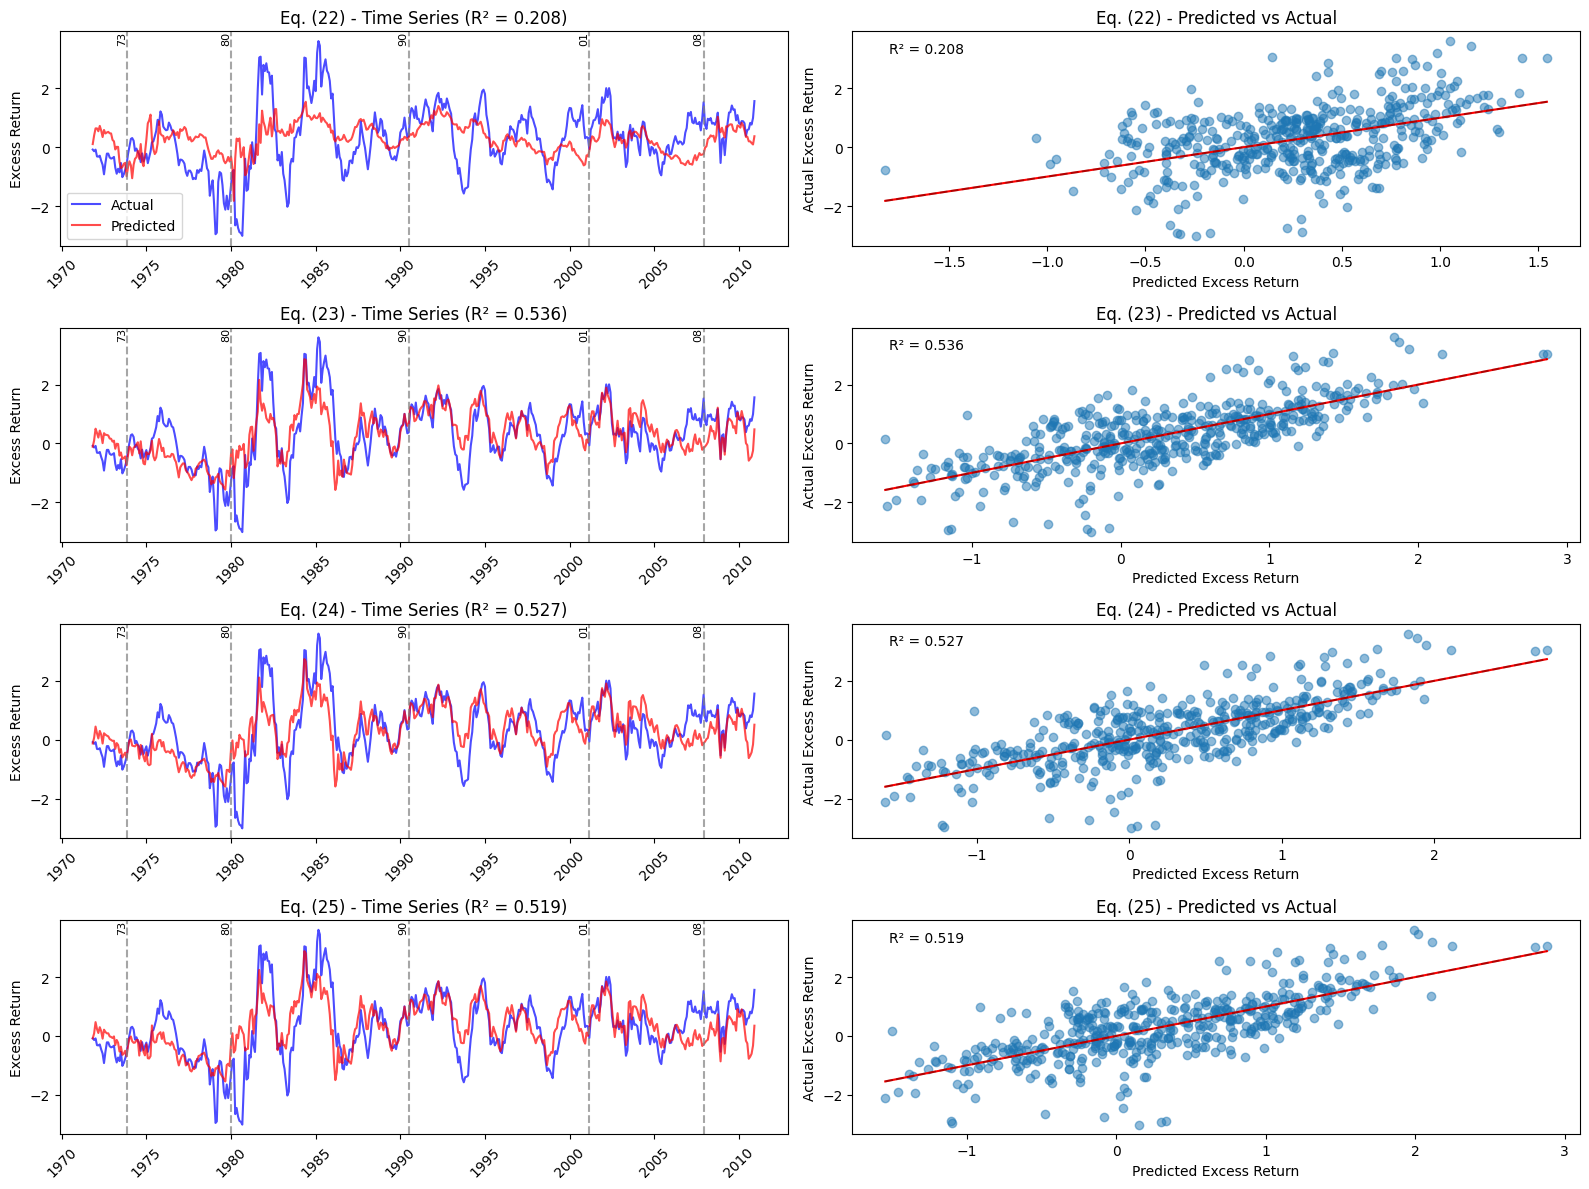

In [6]:
fig, axs = plot_model_predictions(results_set)
plt.show()

# Prediction

In [7]:
# 1. Define the out-of-sample period
test_start = '2011-01-01'
test_end = '2014-01-01'

# 2. Run the out-of-sample prediction and get R2 scores
oos_r2, utils_data = run_oos_prediction(
    results_set=results_set,
    yields=yields,
    xret=xret,
    Tau=Tau,
    cycle_models=models,
    maturities=maturities,
    test_start=test_start,
    test_end=test_end
)

# 3. Print the results
print(f"Out-of-sample R² ({test_start} to {test_end}):")
for k, r2 in oos_r2.items():
    print(f"Eq ({k}): R² = {r2:.4f}")

Out-of-sample R² (2011-01-01 to 2014-01-01):
Eq (22): R² = 0.1271
Eq (23): R² = -2.0786
Eq (24): R² = -1.8319
Eq (25): R² = -2.5669


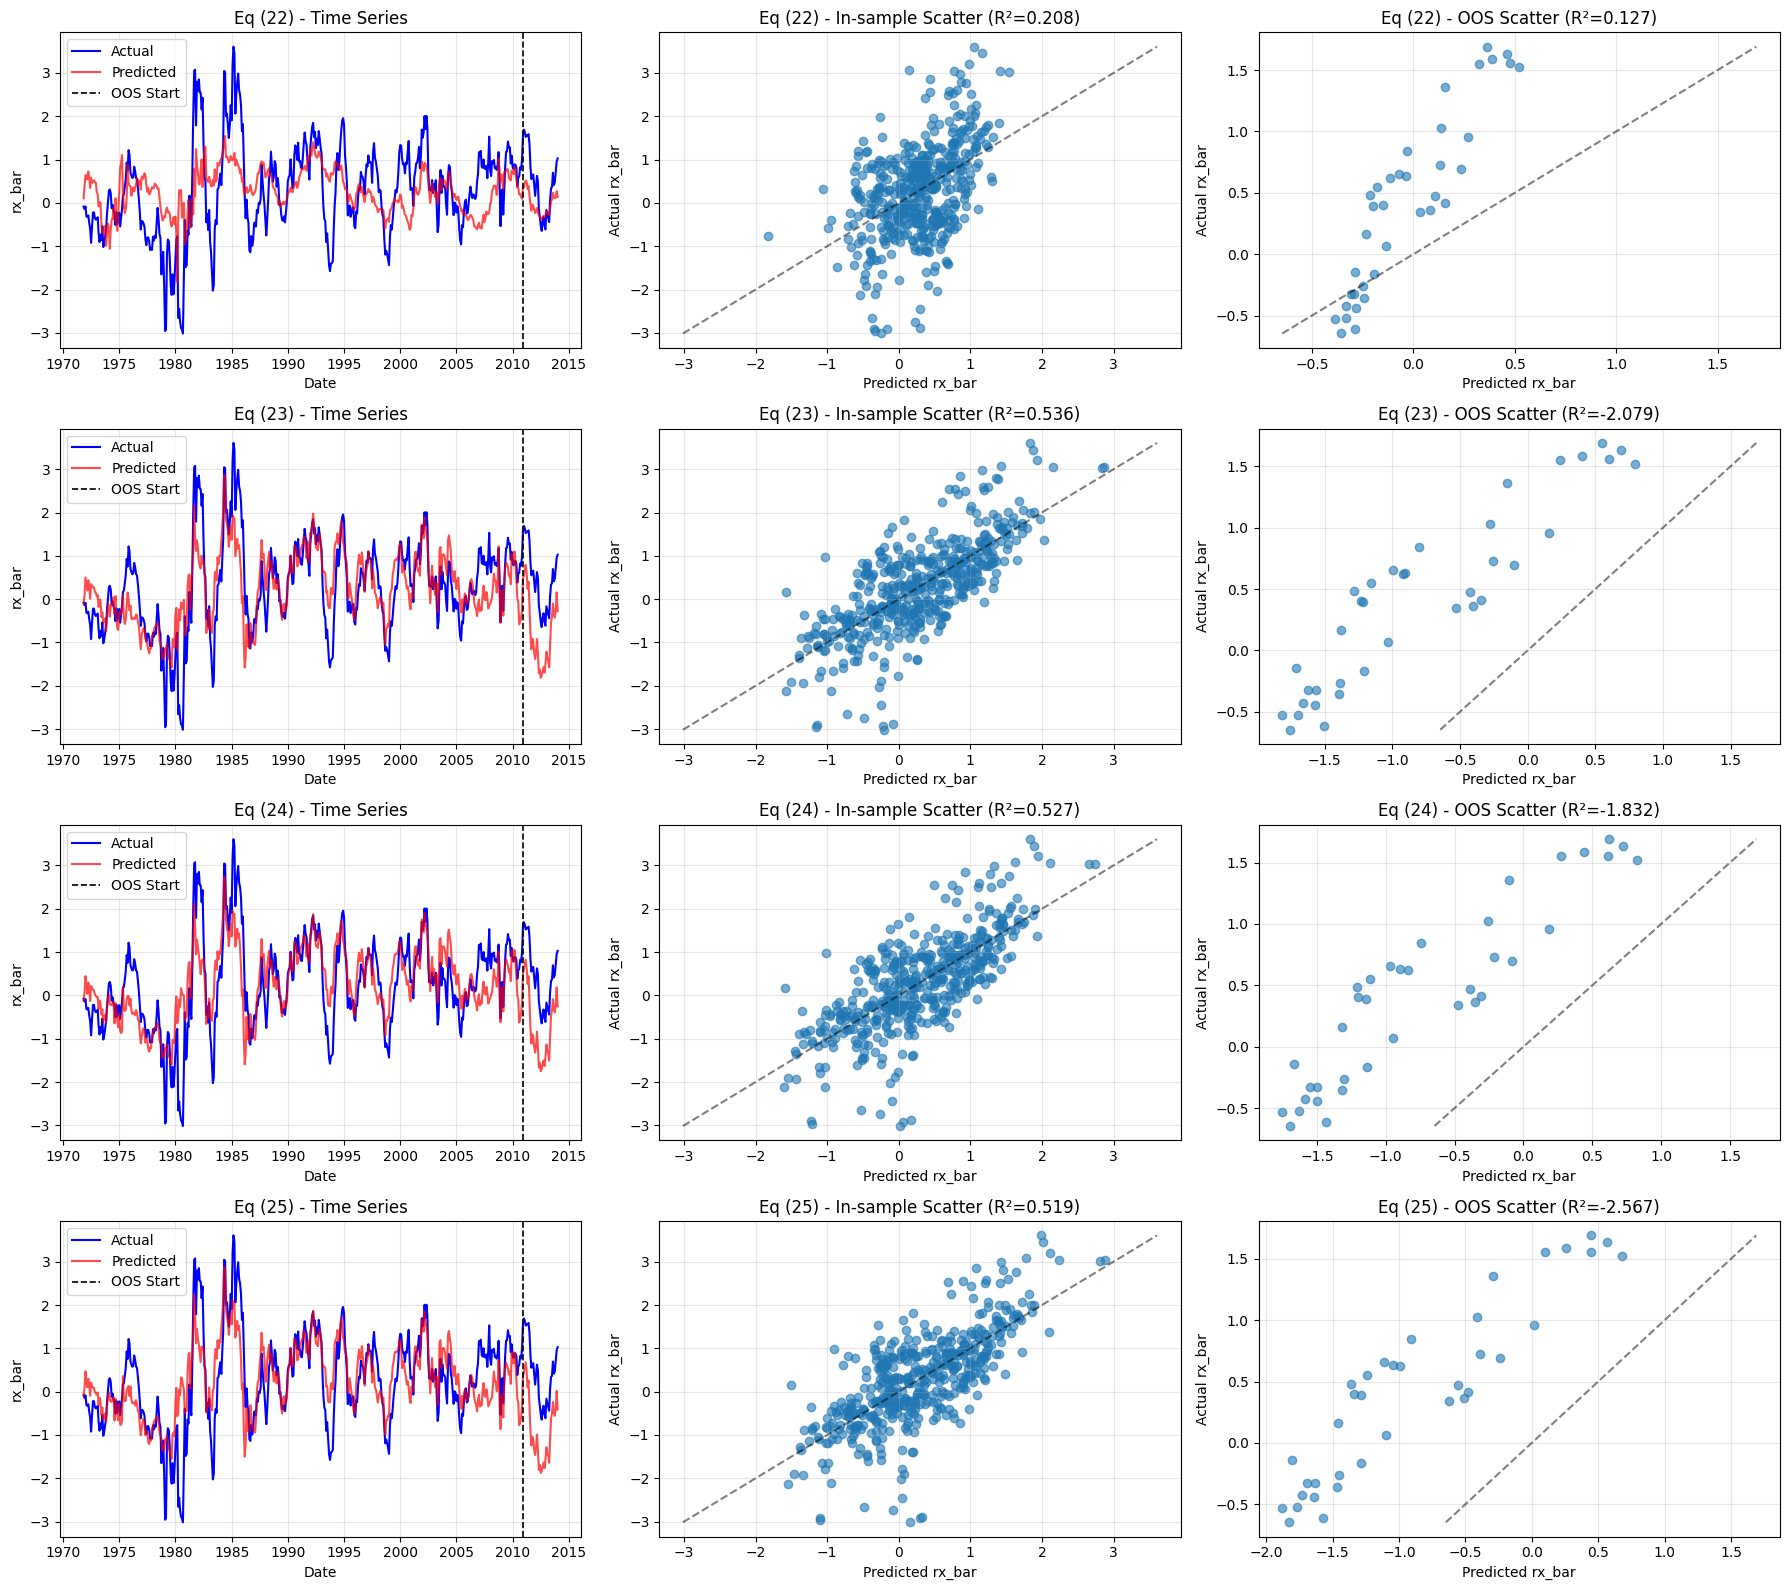

In [8]:
fig, axs = OOS_plot_model_predictions(results_set, oos_r2, utils_data, maturities)
plt.show()

# 3.3 Single return-forecasting factor

CPo also propose an alternative to the CP tent-like factor by regressing $rx^{(n)}_{t+1}$ for different maturities on what they call the "cycle factor" $\widehat{cf}_t$ = $\widehat{\overline{rx_{t+1}}}$, the fitted value of regression (25). 

In [9]:
cf = results_set['models']['25'].fittedvalues
X = sm.add_constant(cf).rename(columns={0: 'cf'})

for maturity in maturities[1:]:  # skip 1-year as no rx1y(1)
    col = f'rx1y({maturity})'
    df_reg = pd.concat([xret_train[col], cf], axis=1).dropna()
    y_dep = df_reg[col]
    res = smf.ols(formula='y_dep ~ cf', data=X).fit(cov_type='HAC', cov_kwds={'maxlags':11})
    print(f'Maturity {maturity} years: R² = {res.rsquared:.4f}')
    print(res.summary().tables[1]) 


Maturity 2 years: R² = 0.3639
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2321      0.202      1.148      0.251      -0.164       0.628
cf             1.4435      0.183      7.892      0.000       1.085       1.802
Maturity 5 years: R² = 0.4459
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2766      0.609      0.454      0.650      -0.917       1.470
cf             5.0371      0.479     10.509      0.000       4.098       5.976
Maturity 7 years: R² = 0.4910
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0631      0.784      0.080      0.936      -1.474       1.600
cf             7.2245      0.641     11.2

# Appendix A: Figure 27.1 from Rebonato (2018)

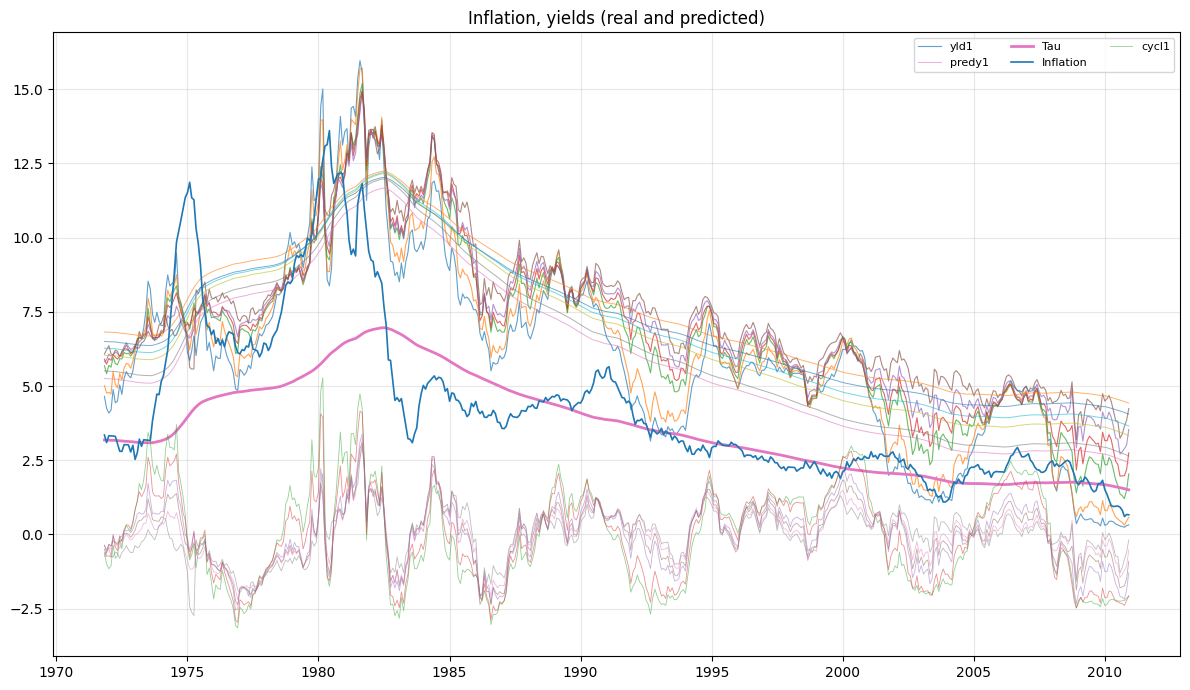

In [10]:
# Figure 27.1: Inflation, yields (real and predicted), secular inflation (Tau) and cycles

# Prepare plot series (all in decimals)
yld_cols = [f'y{n}' for n in maturities]
yld_plot = yields[yld_cols].copy()
yld_plot.columns = [f'yld{n}' for n in maturities]
predy_plot = predy.copy()
cycles_plot = cycles.copy()

plot_df = pd.concat([yld_plot, inflation, Tau, predy_plot, cycles_plot], axis=1).dropna()

# 4) Plot
plt.figure(figsize=(12, 7))
# Top jagged lines: yld1..yld10
for n in maturities:
    plt.plot(plot_df.index, plot_df[f'yld{n}'], lw=0.8, alpha=0.7, label=f'yld{n}' if n==1 else None)
# Smooth predicted yields: predy1..predy10
for n in maturities:
    plt.plot(plot_df.index, plot_df[f'predy{n}'], lw=0.7, alpha=0.6, label=f'predy{n}' if n==1 else None)
# Long-term inflation Tau
plt.plot(plot_df.index, plot_df['Tau'], color='tab:pink', lw=2.0, label='Tau')
# Yearly inflation (blue jagged)
plt.plot(plot_df.index, plot_df['CPILFESL'], color='tab:blue', lw=1.2, label='Inflation')
# Bottom lines: cycles cycl1..cycl10
for n in maturities:
    plt.plot(plot_df.index, plot_df[f'cycl{n}'], lw=0.6, alpha=0.5, label=f'cycl{n}' if n==1 else None)

plt.title('Inflation, yields (real and predicted)')
# plt.ylim(-0.05, 0.20)
plt.grid(alpha=0.3)
plt.legend(ncol=3, fontsize=8)
plt.tight_layout()
plt.show()

# Appendix B: Figure 1A from CPo

We extend the original period from 2011 to 2025.

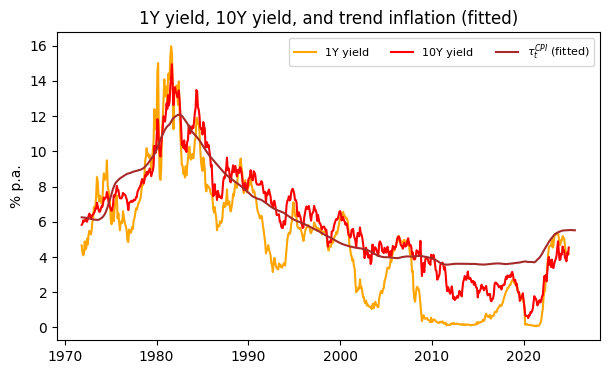

In [11]:
# Figure 1A: 1Y yield, 10Y yield, and trend inflation (fitted)
plt.figure(figsize=(7, 4))
plt.plot(yields['y1'].loc[start:], label='1Y yield', color='orange')
plt.plot(yields['y10'].loc[start:], label='10Y yield', color='red')

# Fit on the training data period
avg_yield_train = yields_train[[f'y{n}' for n in range(1, 16)]].mean(axis=1)
tau_aligned, avg_yield_aligned = Tau_train.align(avg_yield_train, join='inner')
fit_coef = np.polyfit(tau_aligned, avg_yield_aligned, 1)

# Apply the fit to the full Tau series for plotting
tau_fitted = Tau * fit_coef[0] + fit_coef[1]
plt.plot(tau_fitted.loc[start:], label=r'$\tau^{CPI}_t$ (fitted)', color='brown')
plt.title('1Y yield, 10Y yield, and trend inflation (fitted)')
plt.legend(ncol=3, fontsize=8)
plt.ylabel('% p.a.')
plt.show()

# Appendix B.2: Figure 2 from CPo

Correlation(cf, c10) = 0.7077


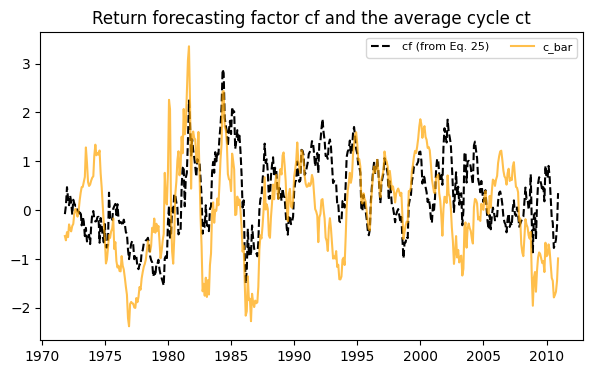

In [12]:
# Figure 2: Return forecasting factor cf and the average cycle ct
c_bar = duration_weighted_average(cycles, type_name="cycle")

plt.figure(figsize=(7, 4))
# plot cf black and dotted 
plt.plot(cf, label='cf (from Eq. 25)', color='black', linestyle='--')
plt.plot(c_bar, label='c_bar', color='orange', alpha=0.7)
plt.legend(ncol=2, fontsize=8)

plt.title('Return forecasting factor cf and the average cycle ct')  


print(f"Correlation(cf, c10) = {cf.corr(cycles['cycl10']):.4f}")
plt.show()